In [1]:
!pip install pytorch-forecasting --quiet
!pip install -U neptune --quiet
!pip install optuna-integration[pytorch_lightning] --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.2 requires botocore<1.35.37,>=1.35.16, but you have botocore 1.35.85 which is incompatible.
s3fs 2024.9.0 requires fsspec==2024.9.0.*, but you have fsspec 2024.6.0 which is incompatible.


In [2]:
import optuna
type(optuna.pruners.NopPruner)

abc.ABCMeta

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer

import pickle

import numpy as np

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


import tensorflow as tf
import tensorboard as tb
from lightning.pytorch.loggers import NeptuneLogger

import neptune
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhNzBiNTg2ZC1iZmVkLTQ3Y2UtOTY2MS1iNWQyN2JjNDI3MGEifQ==",  # replace with your own
    project="DeepLearning-adi/Energy-forecasting"
)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [5]:
tempdf=pd.read_csv('/kaggle/input/power-subregion-datastore1/datastore1/test/2024-11-18.csv')
tempdf

,period,subba,subba-name,parent,parent-name,value,value-units
0,2024-11-19T00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,9993,megawatthours
1,2024-11-19T00,SCE,Southern California Edison,CISO,California Independent System Operator,12700,megawatthours
2,2024-11-19T00,SDGE,San Diego Gas and Electric,CISO,California Independent System Operator,1881,megawatthours
3,2024-11-19T00,VEA,Valley Electric Association,CISO,California Independent System Operator,90,megawatthours
4,2024-11-19T00,COAS,Coast,ERCO,"Electric Reliability Council of Texas, Inc.",14028,megawatthours
...,...,...,...,...,...,...,...
2070,2024-11-18T00,SPRM,City of Springfield - SWPP,SWPP,Southwest Power Pool,349,megawatthours
2071,2024-11-18T00,SPS,Southwestern Public Service Company - SWPP,SWPP,Southwest Power Pool,3759,megawatthours
2072,2024-11-18T00,WAUE,Western Area Power Upper Great Plains East - SWPP,SWPP,Southwest Power Pool,4064,megawatthours
2073,2024-11-18T00,WFEC,Western Farmers Electric Cooperative - SWPP,SWPP,Southwest Power Pool,1098,megawatthours


In [6]:
# Folder containing your CSV files
csv_folder = "/kaggle/input/power-subregion-datastore1/datastore1/train"

# Read and concatenate all CSV files
all_data = []
for file in sorted(os.listdir(csv_folder)):
    if file.endswith(".csv"):
        file_path = os.path.join(csv_folder, file)
        df = pd.read_csv(file_path)
        all_data.append(df)

# Combine all data into a single DataFrame
data = pd.concat(all_data, ignore_index=True)
print(data.head())

          period subba                           subba-name parent  \
0  2023-10-02T00  PGAE             Pacific Gas and Electric   CISO   
1  2023-10-02T00   SCE    Southern California Edison - CISO   CISO   
2  2023-10-02T00  SDGE    San Diego Gas and Electric - CISO   CISO   
3  2023-10-02T00   VEA  Valley Electric Association  - CISO   CISO   
4  2023-10-02T00  COAS                         ERCO - Coast   ERCO   

                                   parent-name  value    value-units  
0       California Independent System Operator   9007  megawatthours  
1       California Independent System Operator   9022  megawatthours  
2       California Independent System Operator   1312  megawatthours  
3       California Independent System Operator     49  megawatthours  
4  Electric Reliability Council of Texas, Inc.  17926  megawatthours  


In [7]:
# Extract date and hour
data['date'] = data['period'].str.split('T').str[0]
data['hour'] = data['period'].str.split('T').str[1]

# Group by date and parent-name to aggregate daily values
daily_data = data.groupby(['date', 'parent-name'], as_index=False)['value'].sum()
print(daily_data.head())


         date                                     parent-name    value
0  2023-10-01          California Independent System Operator   519642
1  2023-10-01     Electric Reliability Council of Texas, Inc.  1327713
2  2023-10-01                                 ISO New England   252238
3  2023-10-01  Midcontinent Independent System Operator, Inc.  1735351
4  2023-10-01            New York Independent System Operator   338210


In [8]:
# Convert 'date' to datetime
data['date'] = pd.to_datetime(data['date'])
daily_data['date'] = pd.to_datetime(daily_data['date'])

# Add week number column
daily_data['week'] = daily_data['date'].dt.isocalendar().week

# Group by week and parent-name to aggregate weekly values
weekly_data = daily_data.groupby(['week', 'parent-name'], as_index=False)['value'].sum()
print(weekly_data.head())


   week                                     parent-name     value
0     1          California Independent System Operator   4069084
1     1     Electric Reliability Council of Texas, Inc.   8335631
2     1                                 ISO New England   2458580
3     1  Midcontinent Independent System Operator, Inc.  13068236
4     1            New York Independent System Operator   3088316


In [9]:
# Add month column
daily_data['month'] = daily_data['date'].dt.month

# Group by month and parent-name to aggregate monthly values
monthly_data = daily_data.groupby(['month', 'parent-name'], as_index=False)['value'].sum()
print(monthly_data.head())


   month                                     parent-name     value
0      1          California Independent System Operator  18197272
1      1     Electric Reliability Council of Texas, Inc.  39870948
2      1                                 ISO New England  11168076
3      1  Midcontinent Independent System Operator, Inc.  60884466
4      1            New York Independent System Operator  14042424


In [10]:
# Split the DataFrame into a dictionary based on parent-name
parent_dict = {name: group for name, group in daily_data.groupby('parent-name')}

# Verify the split
for name, df in parent_dict.items():
    print(f"{name}: {len(df)} rows")


California Independent System Operator: 398 rows
Electric Reliability Council of Texas, Inc.: 398 rows
ISO New England: 398 rows
Midcontinent Independent System Operator, Inc.: 398 rows
New York Independent System Operator: 398 rows
PJM Interconnection, LLC: 398 rows
Public Service Company of New Mexico: 398 rows
Southwest Power Pool: 398 rows


In [11]:
for name, df in parent_dict.items():
    # Apply rolling average for smoothing
    df['value_smoothed'] = df['value'].rolling(window=7, center=True, min_periods=1).mean()

    # Replace the dictionary value with the updated DataFrame
    parent_dict[name] = df


In [12]:
for name, df in parent_dict.items():
    # Interpolate missing or anomalous values
    df['value_interpolated'] = df['value'].interpolate(method='linear')

    # Replace the dictionary value with the updated DataFrame
    parent_dict[name] = df


In [13]:
for name, df in parent_dict.items():
    # Calculate IQR for the group
    Q1 = df['value'].quantile(0.25)
    Q3 = df['value'].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the median
    df['value_cleaned'] = df['value'].apply(
        lambda x: df['value'].median() if x < lower_bound or x > upper_bound else x
    )

    # Replace the dictionary value with the updated DataFrame
    parent_dict[name] = df


In [14]:
# Combine all the updated DataFrames back into one
cleaned_data = pd.concat(parent_dict.values(), ignore_index=True)

# Verify the cleaned data
# print(cleaned_data.head())


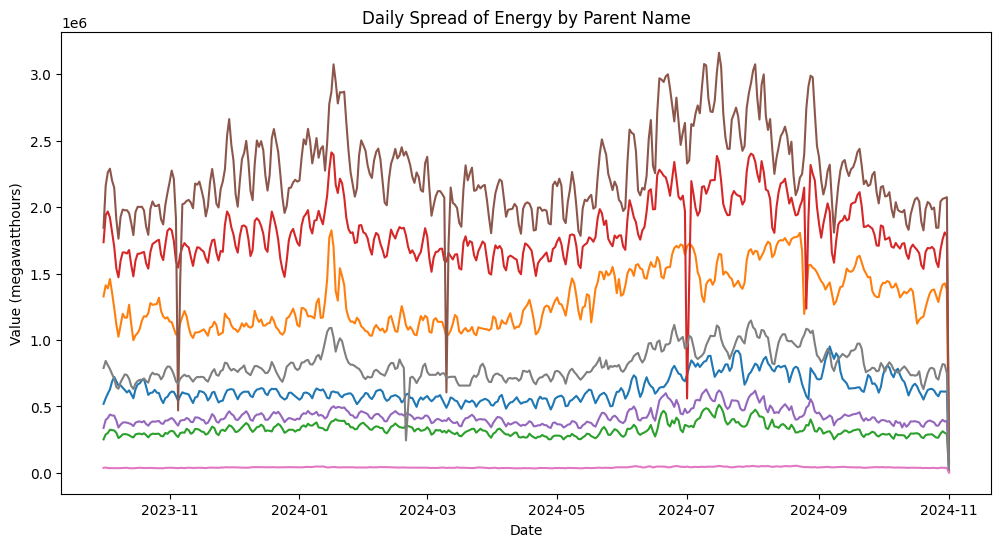

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=cleaned_data, x='date', y='value', hue='parent-name')
plt.title('Daily Spread of Energy by Parent Name')
plt.xlabel('Date')
plt.ylabel('Value (megawatthours)')
plt.legend(title='Parent Name')
legend = plt.legend()
legend.remove()  # Remove the legend
plt.show()


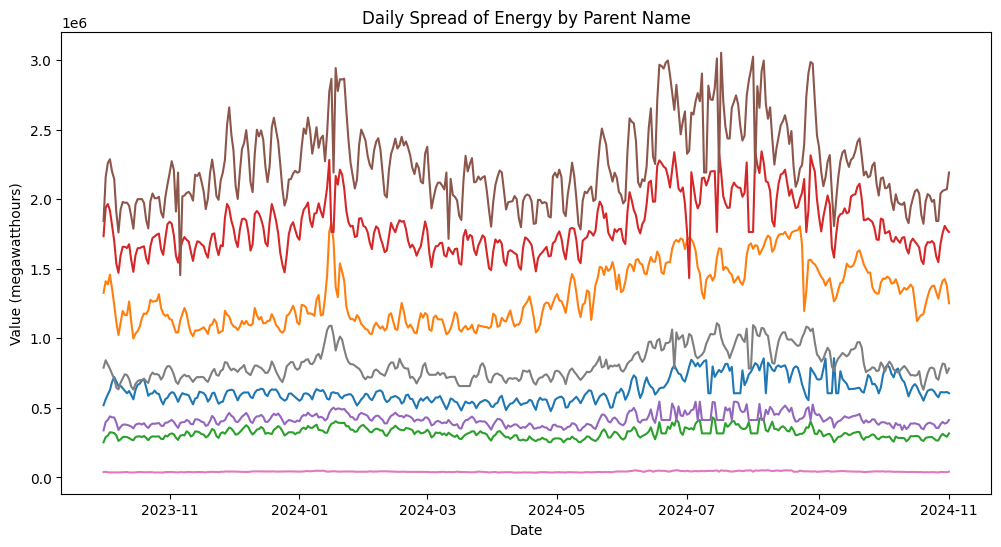

In [16]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=cleaned_data, x='date', y='value_cleaned', hue='parent-name')
plt.title('Daily Spread of Energy by Parent Name')
plt.xlabel('Date')
plt.ylabel('Value (megawatthours)')
plt.legend(title='Parent Name')
legend = plt.legend()
legend.remove()  # Remove the legend
plt.show()


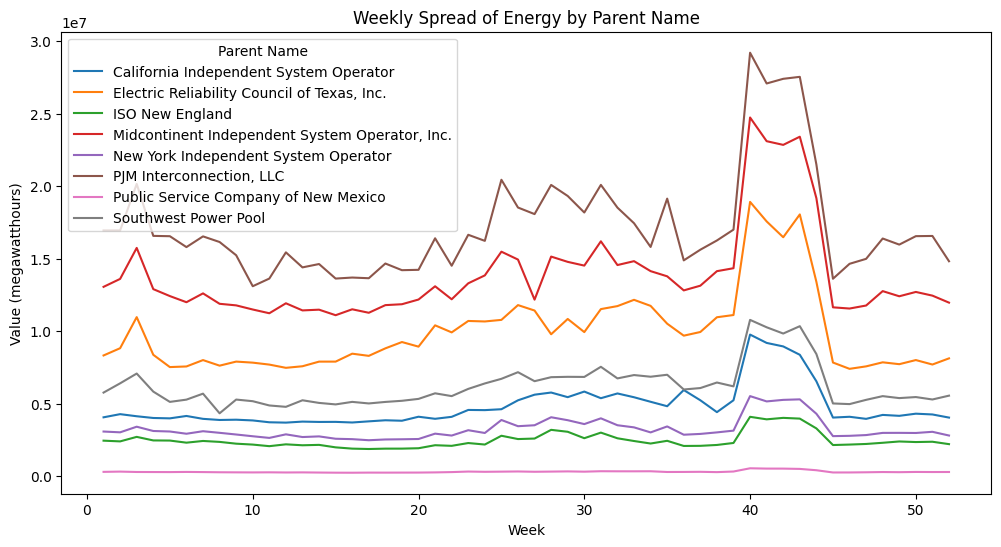

In [17]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_data, x='week', y='value', hue='parent-name')
plt.title('Weekly Spread of Energy by Parent Name')
plt.xlabel('Week')
plt.ylabel('Value (megawatthours)')
plt.legend(title='Parent Name')
plt.show()


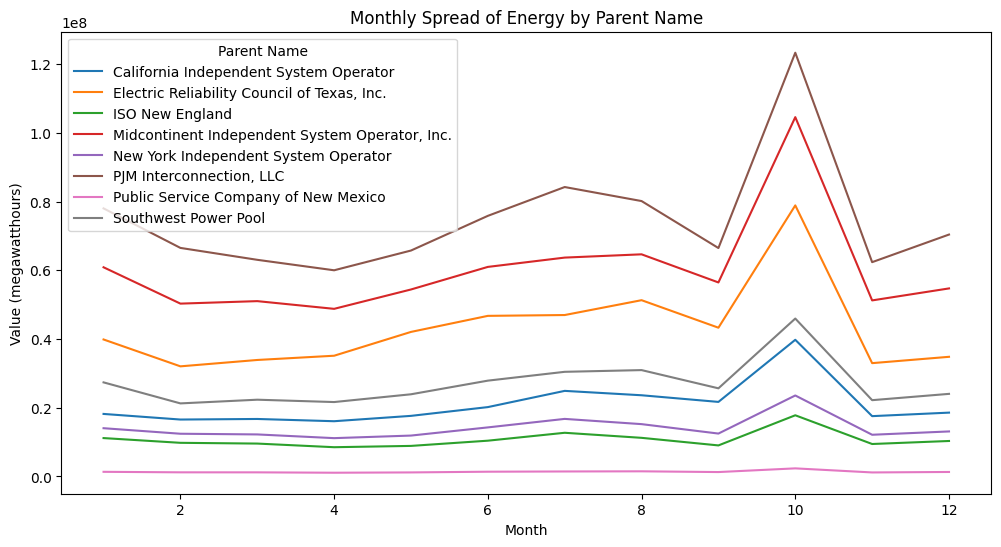

In [18]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_data, x='month', y='value', hue='parent-name')
plt.title('Monthly Spread of Energy by Parent Name')
plt.xlabel('Month')
plt.ylabel('Value (megawatthours)')
plt.legend(title='Parent Name')
plt.show()


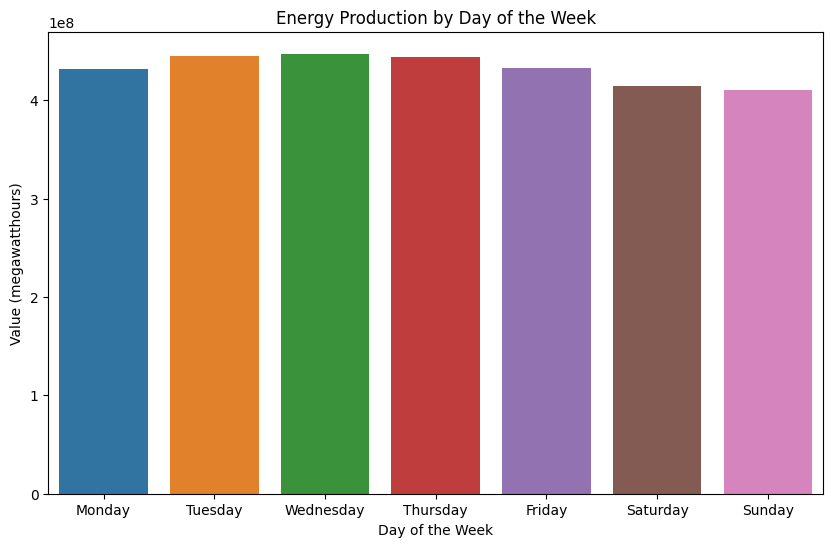

In [19]:
# Add day of the week column
daily_data['day_of_week'] = daily_data['date'].dt.day_name()

# Group by day of the week
day_of_week_data = daily_data.groupby('day_of_week', as_index=False)['value'].sum()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=day_of_week_data, x='day_of_week', y='value', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Energy Production by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Value (megawatthours)')
plt.show()


## Creating TimeseriesDataSet

### Splitting and Melting to create features

In [20]:
import pandas as pd
import numpy as np

# Assume cleaned_data is your processed DataFrame with 'date', 'parent-name', and 'value_cleaned'

# Step 1: Sort the data and set up time features
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])
cleaned_data.sort_values(['parent-name', 'date'], inplace=True)

# Establish the earliest time for relative calculations
earliest_time = cleaned_data['date'].min()

# Create a list to hold all group data
df_list = []

# Iterate through each parent-name (group)
for name, group in cleaned_data.groupby('parent-name'):
    group = group.copy()
    date = group['date']

    # Add time-based features
    group['hours_from_start'] = (date - earliest_time).dt.total_seconds() // 3600
    group['hours_from_start'] = group['hours_from_start'].astype('int')

    group['days_from_start'] = (date - earliest_time).dt.days
    group['hour'] = date.dt.hour  # Hour of day
    group['day'] = date.dt.day  # Day of month
    group['day_of_week'] = date.dt.dayofweek  # Day of week
    group['month'] = date.dt.month  # Month

    # Add a 'parent_name' column as the group identifier
    group['parent_name'] = name

    # Rename target column to 'power_usage'
    group = group.rename(columns={'value_cleaned': 'power_usage'})

    df_list.append(group)

# Combine all groups into one DataFrame
time_df = pd.concat(df_list).reset_index(drop=True)

# Verify the data
print(time_df.head())


        date                             parent-name   value  week  month  \
0 2023-10-01  California Independent System Operator  519642    39     10   
1 2023-10-02  California Independent System Operator  561379    40     10   
2 2023-10-03  California Independent System Operator  596764    40     10   
3 2023-10-04  California Independent System Operator  627770    40     10   
4 2023-10-05  California Independent System Operator  687062    40     10   

   value_smoothed  value_interpolated  power_usage  hours_from_start  \
0   576388.750000              519642     519642.0                 0   
1   598523.400000              561379     561379.0                24   
2   619124.666667              596764     596764.0                48   
3   629277.714286              627770     627770.0                72   
4   648946.285714              687062     687062.0                96   

   days_from_start  hour  day  day_of_week  \
0                0     0    1            6   
1           

In [21]:
time_df.sort_values("days_from_start").groupby("parent-name").days_from_start.diff().dropna() == 1

1195    True
797     True
1       True
399     True
1991    True
        ... 
2785    True
1193    True
1591    True
795     True
397     True
Name: days_from_start, Length: 3176, dtype: bool

In [22]:
# Check if all groups have continuous and non-missing days_from_start
group_missing_check = (
    time_df.groupby("parent_name")
    .apply(lambda x: x["days_from_start"].is_monotonic_increasing and not x["days_from_start"].isnull().any())
)

print("Groups with missing or non-monotonic time steps:")
print(group_missing_check[~group_missing_check])


Groups with missing or non-monotonic time steps:
Series([], dtype: bool)


/tmp/ipykernel_23/3878884408.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x["days_from_start"].is_monotonic_increasing and not x["days_from_start"].isnull().any())


In [23]:
# Check the maximum and minimum days_from_start
print("Max days_from_start:", time_df["days_from_start"].max())
print("Min days_from_start:", time_df["days_from_start"].min())
max_encoder_length = 60  # Look back 60 time steps (days)
max_prediction_length = 14  # Predict 14 time steps (days)

# Print the cutoff value
training_cutoff = time_df["days_from_start"].max() - max_prediction_length
print(f"Training cutoff: {training_cutoff}")

# Check how much data remains after cutoff
remaining_data = time_df[time_df["days_from_start"] <= training_cutoff]
print("Remaining data after cutoff:")
print(remaining_data["parent_name"].value_counts())


Max days_from_start: 397
Min days_from_start: 0
Training cutoff: 383
Remaining data after cutoff:
parent_name
California Independent System Operator            384
Electric Reliability Council of Texas, Inc.       384
ISO New England                                   384
Midcontinent Independent System Operator, Inc.    384
New York Independent System Operator              384
PJM Interconnection, LLC                          384
Public Service Company of New Mexico              384
Southwest Power Pool                              384
Name: count, dtype: int64


In [24]:
# Check if each group has enough data points
required_length = max_encoder_length + max_prediction_length
group_lengths = time_df.groupby("parent_name")["days_from_start"].nunique()

print("Groups with insufficient lengths:")
print(group_lengths[group_lengths < required_length])


Groups with insufficient lengths:
Series([], Name: days_from_start, dtype: int64)


In [25]:
# Reindex each group to ensure continuous time steps
import pandas as pd

# Create a complete range of time steps for each group
full_time_range = (
    time_df.groupby("parent_name")
    .apply(lambda x: x.set_index("days_from_start").reindex(range(x["days_from_start"].min(), x["days_from_start"].max() + 1)))
    .drop("parent_name", axis=1)
    .reset_index()
)

# Fill missing values (forward fill for simplicity)
full_time_range = full_time_range.ffill().bfill()
full_time_range.rename(columns={"index": "days_from_start"}, inplace=True)

# Verify
print(full_time_range.head())
time_df = full_time_range


                              parent_name  days_from_start       date  \
0  California Independent System Operator                0 2023-10-01   
1  California Independent System Operator                1 2023-10-02   
2  California Independent System Operator                2 2023-10-03   
3  California Independent System Operator                3 2023-10-04   
4  California Independent System Operator                4 2023-10-05   

                              parent-name   value  week  month  \
0  California Independent System Operator  519642    39     10   
1  California Independent System Operator  561379    40     10   
2  California Independent System Operator  596764    40     10   
3  California Independent System Operator  627770    40     10   
4  California Independent System Operator  687062    40     10   

   value_smoothed  value_interpolated  power_usage  hours_from_start  hour  \
0   576388.750000              519642     519642.0                 0     0   
1   5985

/tmp/ipykernel_23/1908260551.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index("days_from_start").reindex(range(x["days_from_start"].min(), x["days_from_start"].max() + 1)))


In [26]:
# Define safe lags
lags = {"power_usage": [1, 2, 3, 7]}  # Lagging 1, 2, 3, and 7 days back

# Create the TimeSeriesDataSet
training = TimeSeriesDataSet(
    time_df[lambda x: x.days_from_start <= training_cutoff],
    time_idx="days_from_start",
    target="power_usage",
    group_ids=["parent_name"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["parent_name"],
    time_varying_known_reals=["days_from_start", "day", "day_of_week", "month", "hour"],
    time_varying_unknown_reals=["power_usage"],
    lags=lags,  # Add lags here
    target_normalizer=GroupNormalizer(groups=["parent_name"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)
print("Training dataset with lags created successfully!")


Training dataset with lags created successfully!


In [27]:
# Create the validation dataset
validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# Create DataLoaders
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=3)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=3)

In [28]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).to("cuda")
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/tmp/ipykernel_23/2362106969.py:2: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pyto

52498.1953125

In [29]:

# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [31]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
# logger = TensorBoardLogger("lightning_logs")  
# {'gradient_clip_val': 0.6083678399431233, 'hidden_size': 111, 'dropout': 0.18597349678623726, 'hidden_continuous_size': 59, 'attention_head_size': 3, 'learning_rate': 0.04131023884248371}
trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.6,
    #callbacks=[lr_logger],
    callbacks=[lr_logger, early_stop_callback],
    logger=neptune_logger)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.041,
    hidden_size=111,
    attention_head_size=3,
    dropout=0.186,
    hidden_continuous_size=59,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/opt/conda/lib/python3.10/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 0.0


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 47308.438


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 48.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous ope

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 5957.699 >= min_delta = 1e-05. New best score: 41350.738


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 95.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 96.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 95.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 95.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 95.0
[neptune] [error  ] Error occurred during asynchronous operation process

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 6755.586 >= min_delta = 1e-05. New best score: 34595.152


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 143.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 144.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 143.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 143.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 143.0
[neptune] [error  ] Error occurred during asynchronous operation pr

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1090.629 >= min_delta = 1e-05. New best score: 33504.523


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 191.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 191.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 191.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 191.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 191.0
[neptune] [error  ] Error occurred during asynchrono

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 239.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 239.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 239.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 239.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 240.0
[neptune] [error  ] Error occurred during asynchronous

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 334.594 >= min_delta = 1e-05. New best score: 33169.930


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 287.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 288.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 287.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 287.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 287.0
[neptune] [error  ] Error occurred during asynchronous operation pr

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 335.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 335.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 335.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 335.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 335.0
[neptune] [error  ] Error occurred during asynchronous

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 384.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 383.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 383.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 383.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 383.0
[neptune] [error  ] Error occurred during asynchronous operation p

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 431.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 431.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 431.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 431.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 431.0
[neptune] [error  ] Error occurred during asynchronous oper

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 479.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 479.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 480.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 479.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 479.0
[neptune] [error  ] Error occurred during asynchronous operat

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 371.262 >= min_delta = 1e-05. New best score: 32798.668


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 527.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 527.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 527.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 527.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 527.0
[neptune] [error  ] Error occurred during asynchronous operation p

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 2033.713 >= min_delta = 1e-05. New best score: 30764.955


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 575.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 575.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 575.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 575.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 576.0
[neptune] [error  ] Error occurred during asynchronous operation p

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 623.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 623.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 623.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 624.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 623.0
[neptune] [error  ] Error occurred during asynchrono

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 671.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 671.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 671.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 671.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 672.0
[neptune] [error  ] Error occurred during asynchronous oper

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 719.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 720.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 719.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 719.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 719.0
[neptune] [error  ] Error occurred during asynchronous operation pro

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 767.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 767.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 767.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 767.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 767.0
[neptune] [error  ] Error occurred during asynchrono

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1640.879 >= min_delta = 1e-05. New best score: 29124.076


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 815.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 815.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 815.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 815.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 816.0
[neptune] [error  ] Error occurred during asynchronou

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1987.510 >= min_delta = 1e-05. New best score: 27136.566


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 863.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 863.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 863.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 863.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 864.0
[neptune] [error  ] Error occurred during asynchronous operation pr

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 911.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 911.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 911.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 911.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 911.0
[neptune] [error  ] Error occurred during asynchronous oper

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 959.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 959.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 959.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 959.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 960.0
[neptune] [error  ] Error occurred during asynchronous ope

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 1007.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 1008.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 1007.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 1007.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1007.0
[neptune] [error  ] Error occurred during asynchro

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 1055.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 1055.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 1055.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 1056.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 1055.0
[neptune] [error  ] Error occurred during asynch

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 710.213 >= min_delta = 1e-05. New best score: 26426.354


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 1103.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 1103.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 1103.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 1103.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 1104.0
[neptune] [error  ] Error occurred during asynch

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 1151.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1151.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1151.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 1151.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 1151.0
[neptune] [error  ] Error occurred during asynchronous operat

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 1200.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchr

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 1248.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1247.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1247.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 1247.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 1247.0
[neptune] [error  ] Error occurred during asynchronous operatio

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 1295.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 1296.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 1295.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 1295.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 1295.0
[neptune] [error  ] Error occurred during asynchronous o

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 5 records. Best score: 26426.354. Signaling Trainer to stop.


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 1343.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 1343.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1343.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1343.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 1343.0
[neptune] [error  ] Error occurred during asynchrono

In [32]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/kaggle/working/.neptune/EN-6/EN-6/checkpoints/epoch=27-step=1344.ckpt


/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [33]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to('cuda')
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


57585.796875
tensor([ 27703.2246, 130596.8750,  18876.2344,  75637.6484,  19206.3262,
        142394.0156,   1772.4077,  44499.6680], device='cuda:0')


In [34]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
#('output', 'x', 'index', 'decoder_lengths', 'y')

print('\n')
print(raw_predictions.output._fields)
# ('prediction',
# 'encoder_attention',
# 'decoder_attention',
# 'static_variables',
# 'encoder_variables',
# 'decoder_variables',
# 'decoder_lengths',
# 'encoder_lengths')

print('\n')
print(raw_predictions.output.prediction.shape)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


('output', 'x', 'index', 'decoder_lengths', 'y')


('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([8, 14, 7])


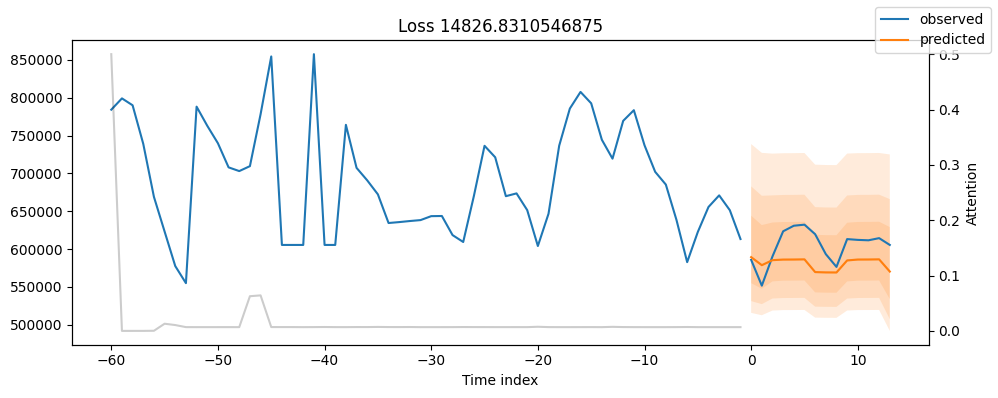

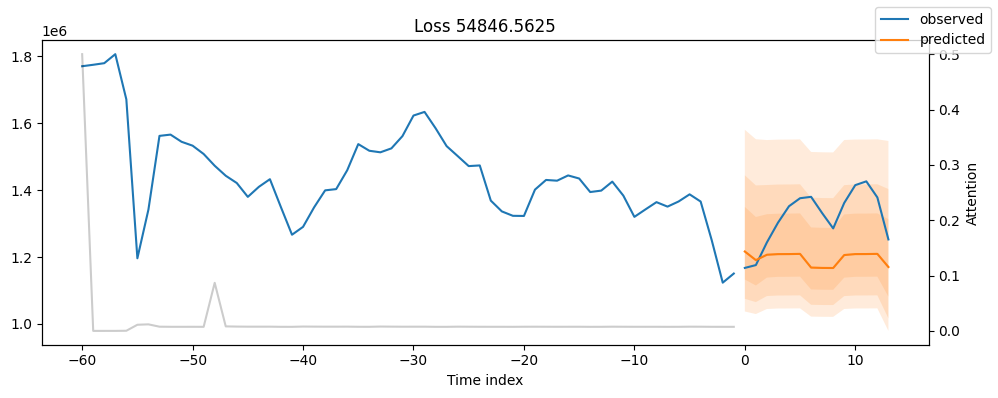

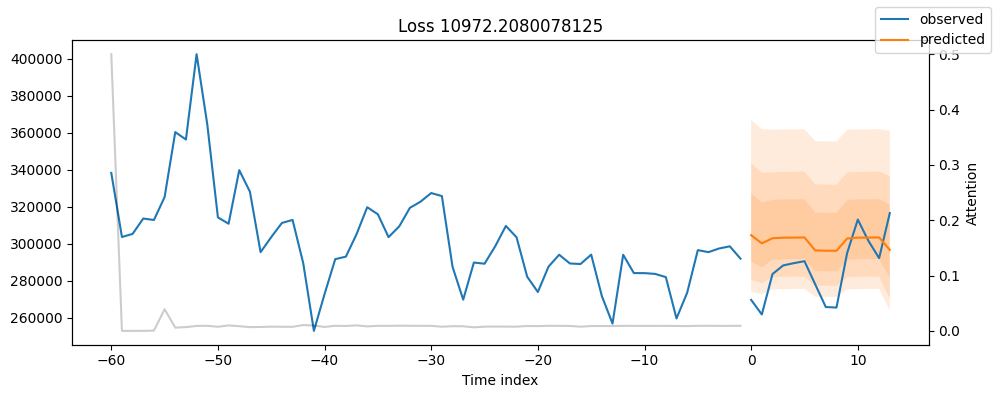

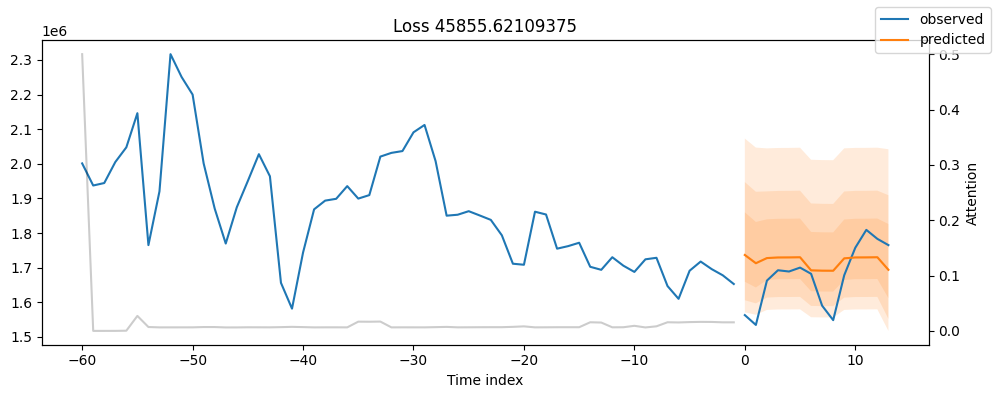

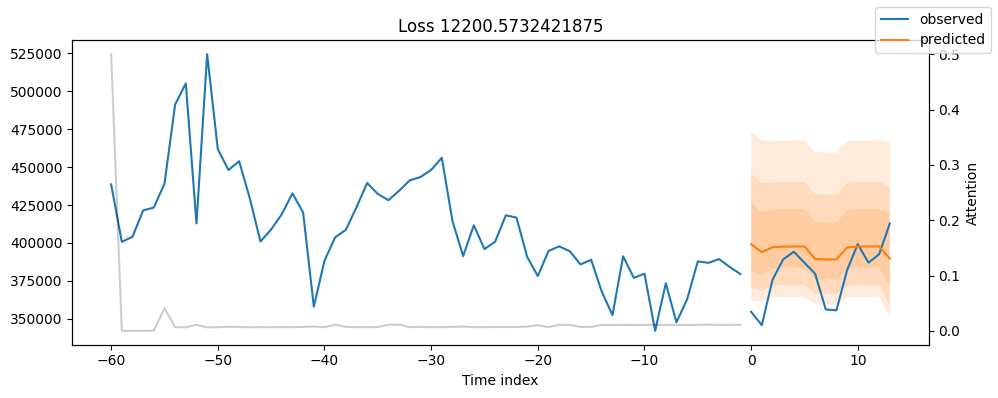

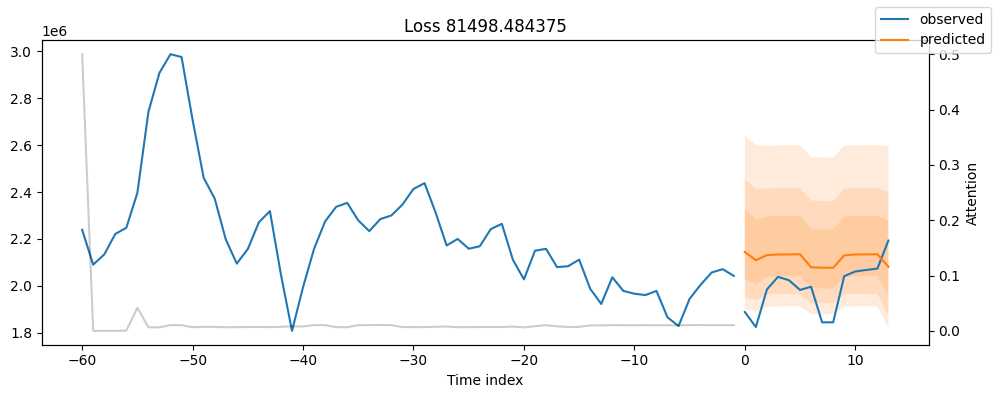

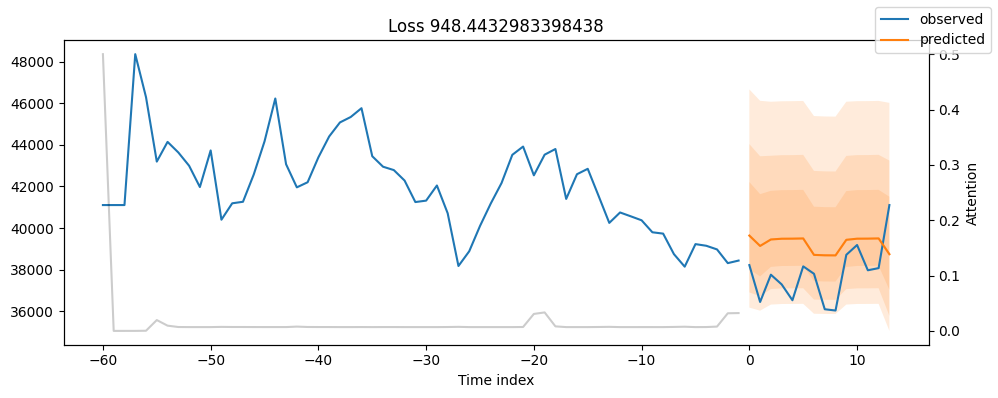

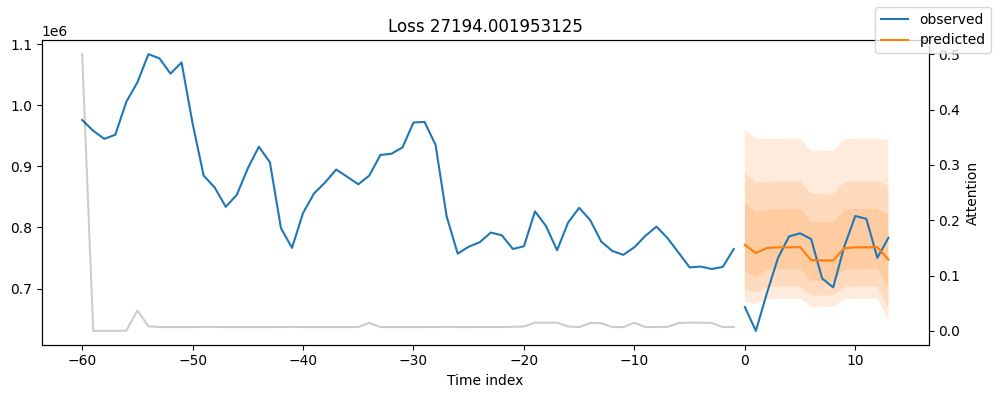

In [35]:
for idx in range(8):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)


In [ ]:
# import shutil
# shutil.rmtree("optuna_test")

In [36]:
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=10,
    max_epochs=25,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(64, 512),
    hidden_continuous_size_range=(30, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.0001, 0.2),
    dropout_range=(0.1, 0.5),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=True,
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    trainer_kwargs={"log_every_n_steps":10,
                    # "enable_model_summary":True,
                    "gradient_clip_val":0.6,
                    "callbacks":[lr_logger],
                    "logger":neptune_logger}
    
)

# save study results
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# print best hyperparameters
print(study.best_trial.params)

[I 2024-12-19 22:54:35,910] A new study created in memory with name: no-name-bb53cbc9-ebb3-4478-9c31-e7d8f1333bd3
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to i

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.00023073490555668142
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_eb67bec4-3d7d-40cd-9ab0-b3ff523b9b47.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_eb67bec4-3d7d-40cd-9ab0-b3ff523b9b47.ckpt
[I 2024-12-19 22:54:52,694] Using learning rate of 0.000269
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/.neptune/EN-6/EN-6/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 19.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 29.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 19.0
[neptune] [error  ] Error occurred during asynchronous operati

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 48.0
[neptune] [error  ] Error occurred during asynchronous operation proces

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
[I 2024-12-19 23:01:43,509] Trial 0 finished with value: 28128.474609375 and parameters: {'gradient_clip_val': 0.3644997717949215, 'hidden_size': 273, 'dropout': 0.4936619338914189, 'hidden_continuous_size': 88, 'attention_head_size': 3, 'learning_rate': 0.00026861725048627085}. Best is trial 0 with value: 28128.474609375.
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asyn

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0012284002568219974
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_70e9ac67-397e-44db-b05b-7ad5e5c7aec4.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_70e9ac67-397e-44db-b05b-7ad5e5c7aec4.ckpt
[I 2024-12-19 23:02:12,752] Using learning rate of 0.000669
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/.neptune/EN-6/EN-6/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 19.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 29.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 0.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation proces

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation proces

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
[I 2024-12-19 23:10:39,850] Trial 1 finished with value: 23039.859375 and parameters: {'gradient_clip_val': 0.04667015547841822, 'hidden_size': 382, 'dropout': 0.39732683228832977, 'hidden_continuous_size': 83, 'attention_head_size': 1, 'learning_rate': 0.0006687403049764221}. Best is trial 1 with value: 23039.859375.
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchrono

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.00023073490555668142
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_97105a8e-aa5f-4bc1-97c9-d694291ef4ca.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_97105a8e-aa5f-4bc1-97c9-d694291ef4ca.ckpt
[I 2024-12-19 23:11:05,133] Using learning rate of 0.000231
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/.neptune/EN-6/EN-6/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 19.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 29.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 39.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 0.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-c

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous o

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
[I 2024-12-19 23:16:02,785] Trial 2 finished with value: 26533.52734375 and parameters: {'gradient_clip_val': 0.03217421741710088, 'hidden_size': 166, 'dropout': 0.44550827830481565, 'hidden_continuous_size': 80, 'attention_head_size': 4, 'learning_rate': 0.00023073490555668142}. Best is trial 1 with value: 23039.859375.
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore t

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous oper

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0004573050519273264
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_9027d17f-65d9-4deb-839f-ddb688545dad.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_9027d17f-65d9-4deb-839f-ddb688545dad.ckpt
[I 2024-12-19 23:16:20,986] Using learning rate of 0.000669
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/.neptune/EN-6/EN-6/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 0.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 19.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 29.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 39.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-c

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operatio

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
[I 2024-12-19 23:19:05,415] Trial 3 finished with value: 21557.484375 and parameters: {'gradient_clip_val': 0.853576685678019, 'hidden_size': 67, 'dropout': 0.42099587368841807, 'hidden_continuous_size': 34, 'attention_head_size': 4, 'learning_rate': 0.0006687403049764221}. Best is trial 3 with value: 21557.484375.
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them us

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asyn

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.00026861725048627085
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_f00e28b1-876c-4fd4-8d61-8524e7f88213.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_f00e28b1-876c-4fd4-8d61-8524e7f88213.ckpt
[I 2024-12-19 23:19:19,928] Using learning rate of 0.000337
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/.neptune/EN-6/EN-6/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 0.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 19.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 29.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 39.0
[neptune] [error  ] Error occurred durin

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
[I 2024-12-19 23:23:03,784] Trial 4 finished with value: 29737.771484375 and parameters: {'gradient_clip_val': 0.26336019730667315, 'hidden_size': 118, 'dropout': 0.10125462933694891, 'hidden_continuous_size': 47, 'attention_head_size': 1, 'learning_rate': 0.00033741532148042456}. Best is trial 3 with value: 21557.484375.
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore 

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asyn

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0004238339085209166
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_040e52ba-3bc2-46dd-853a-07f73d2e9e4d.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_040e52ba-3bc2-46dd-853a-07f73d2e9e4d.ckpt
[I 2024-12-19 23:23:25,806] Using learning rate of 0.000364
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/.neptune/EN-6/EN-6/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 19.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 29.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 0.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation proces

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous op

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
[I 2024-12-19 23:31:08,545] Trial 5 finished with value: 36825.8984375 and parameters: {'gradient_clip_val': 0.03210946742090297, 'hidden_size': 329, 'dropout': 0.16438849777821962, 'hidden_continuous_size': 86, 'attention_head_size': 4, 'learning_rate': 0.00036406178932015806}. Best is trial 3 with value: 21557.484375.
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore th

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operati

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.00024895657436959794
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_da086b8a-3151-4c9f-8486-7e40694613b3.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_da086b8a-3151-4c9f-8486-7e40694613b3.ckpt
[I 2024-12-19 23:31:30,191] Using learning rate of 0.000269
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/.neptune/EN-6/EN-6/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 19.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 29.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 39.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 0.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-c

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 48.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation 

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
[I 2024-12-19 23:34:39,114] Trial 6 finished with value: 20760.208984375 and parameters: {'gradient_clip_val': 0.016720915003011504, 'hidden_size': 71, 'dropout': 0.13012779383482226, 'hidden_continuous_size': 43, 'attention_head_size': 3, 'learning_rate': 0.00026861725048627085}. Best is trial 6 with value: 20760.208984375.
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to igno

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operati

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.00026861725048627085
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_be28a21c-2f7e-42d6-9ca2-82dbfc18e1e7.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_be28a21c-2f7e-42d6-9ca2-82dbfc18e1e7.ckpt
[I 2024-12-19 23:34:58,656] Using learning rate of 0.000231
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/.neptune/EN-6/EN-6/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 0.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 19.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 29.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation proces

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 48.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous oper

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
[I 2024-12-19 23:41:57,890] Trial 7 finished with value: 34402.59375 and parameters: {'gradient_clip_val': 0.02313107300372229, 'hidden_size': 297, 'dropout': 0.4720895076442855, 'hidden_continuous_size': 32, 'attention_head_size': 2, 'learning_rate': 0.00023073490555668142}. Best is trial 6 with value: 20760.208984375.
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore th

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during async

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.00023073490555668142
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_8c4d0b0e-49c2-418b-b42b-87dad1577dfd.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_8c4d0b0e-49c2-418b-b42b-87dad1577dfd.ckpt
[I 2024-12-19 23:42:20,154] Using learning rate of 0.000393
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/.neptune/EN-6/EN-6/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 19.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 29.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 39.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation process

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 48.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous oper

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
[I 2024-12-19 23:45:59,585] Trial 8 finished with value: 28657.388671875 and parameters: {'gradient_clip_val': 0.03940554142843296, 'hidden_size': 94, 'dropout': 0.1799322660933426, 'hidden_continuous_size': 90, 'attention_head_size': 1, 'learning_rate': 0.00039281259031589234}. Best is trial 6 with value: 20760.208984375.
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 1199.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 1199.0
[neptune] [error  ] Error occurred during async

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.00024895657436959794
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_5d20635e-aed0-429f-a59a-c0c3ee2a89f8.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_5d20635e-aed0-429f-a59a-c0c3ee2a89f8.ckpt
[I 2024-12-19 23:46:15,965] Using learning rate of 0.000313
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/.neptune/EN-6/EN-6/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 9.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 19.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 29.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 39.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 0.0
[neptune] [error  ] Error occurred durin

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/lr-Adam. Invalid point: 48.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous op

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
[I 2024-12-19 23:50:19,483] Trial 9 finished with value: 32292.19921875 and parameters: {'gradient_clip_val': 0.15975152581591967, 'hidden_size': 117, 'dropout': 0.46891048451044315, 'hidden_continuous_size': 76, 'attention_head_size': 4, 'learning_rate': 0.00031271916611281256}. Best is trial 6 with value: 20760.208984375.


{'gradient_clip_val': 0.016720915003011504, 'hidden_size': 71, 'dropout': 0.13012779383482226, 'hidden_continuous_size': 43, 'attention_head_size': 3, 'learning_rate': 0.00026861725048627085}


In [38]:
#{'gradient_clip_val': 0.11286342111100336, 'hidden_size': 194, 'dropout': 0.4971993874361771, 'hidden_continuous_size': 38, 'attention_head_size': 3, 'learning_rate': 0.00024895657436959794}
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
# logger = TensorBoardLogger("lightning_logs")  
# {'gradient_clip_val': 0.6083678399431233, 'hidden_size': 111, 'dropout': 0.18597349678623726, 'hidden_continuous_size': 59, 'attention_head_size': 3, 'learning_rate': 0.04131023884248371}
trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=study.best_trial.params['gradient_clip_val'],
    #callbacks=[lr_logger],
    callbacks=[early_stop_callback],
    logger=neptune_logger)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=study.best_trial.params['learning_rate'],
    hidden_size=study.best_trial.params['hidden_size'],
    attention_head_size=study.best_trial.params['attention_head_size'],
    dropout=study.best_trial.params['dropout'],
    hidden_continuous_size=study.best_trial.params['hidden_continuous_size'],
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 40     | train
3  | prescalers                         | ModuleDict                      | 1.2 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 32.3 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 121 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 63853.035


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 47.0
[neptune] [error  ] Error occurred during asynchronous ope

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 36557.734 >= min_delta = 1e-05. New best score: 27295.299


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 95.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 95.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 95.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 95.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 95.0
[neptune] [error  ] Error occurred during asynchronous operati

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 571.951 >= min_delta = 1e-05. New best score: 26723.348


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 143.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 143.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 143.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 143.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 143.0
[neptune] [error  ] Error occurred during asynchronou

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 191.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 191.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 191.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 191.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 191.0
[neptune] [error  ] Error occurred during asynchronous

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 3076.834 >= min_delta = 1e-05. New best score: 23646.514


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 239.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 239.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 239.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 239.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 239.0
[neptune] [error  ] Error occurred during asynchronous oper

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 180.914 >= min_delta = 1e-05. New best score: 23465.600


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 287.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 287.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 287.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 287.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 287.0
[neptune] [error  ] Error occurred during asynchronous ope

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 335.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 335.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 335.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 335.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 335.0
[neptune] [error  ] Error occurred during asynchrono

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 383.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 383.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 383.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 383.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 383.0
[neptune] [error  ] Error occurred during asynchrono

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 431.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 431.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 431.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 431.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 431.0
[neptune] [error  ] Error occurred during asynchrono

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 479.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 479.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 479.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 479.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 479.0
[neptune] [error  ] Error occurred during asynchronous oper

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 5 records. Best score: 23465.600. Signaling Trainer to stop.


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 527.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 527.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 527.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 527.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 527.0
[neptune] [error  ] Error occurred during asynchrono

In [39]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/kaggle/working/.neptune/EN-6/EN-6/checkpoints/epoch=10-step=528.ckpt


/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


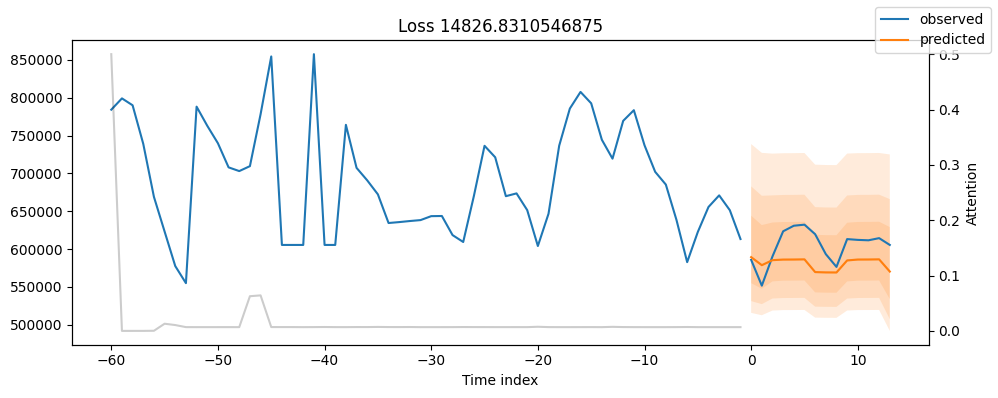

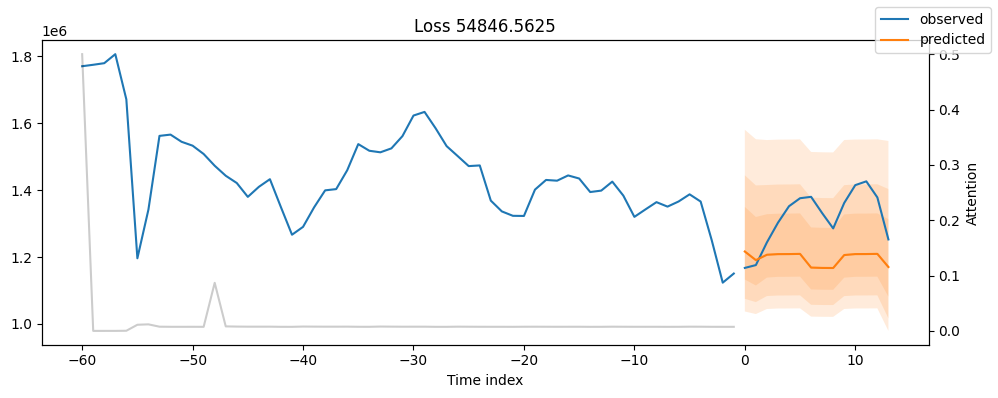

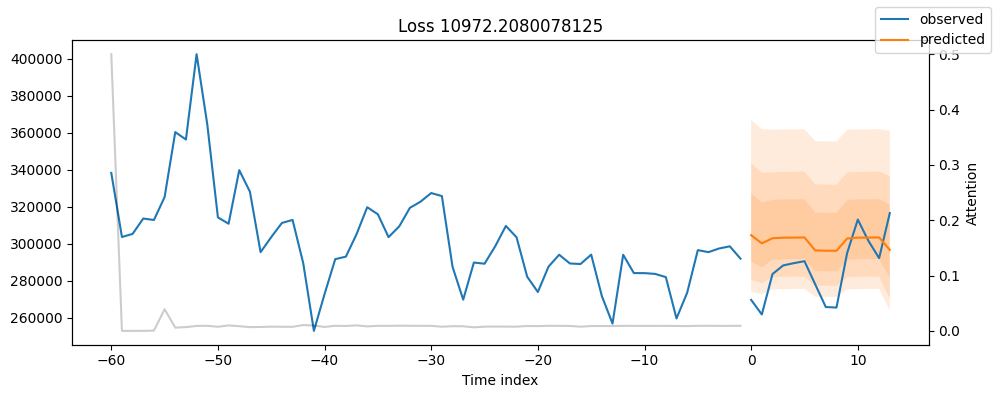

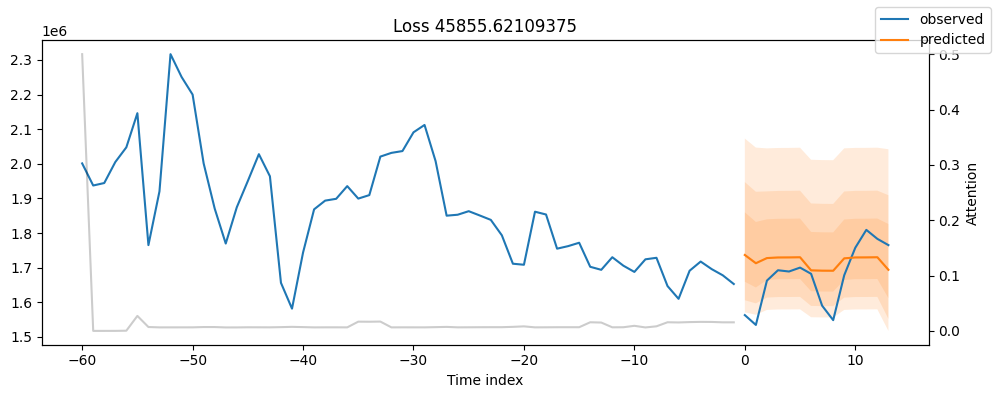

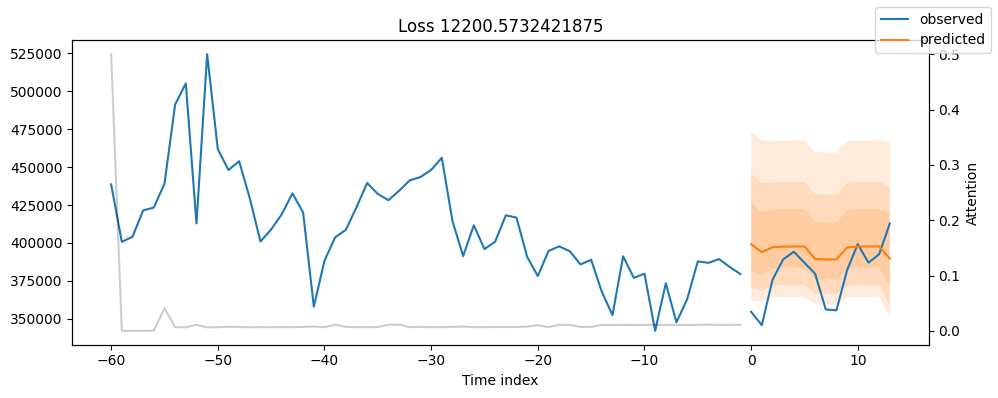

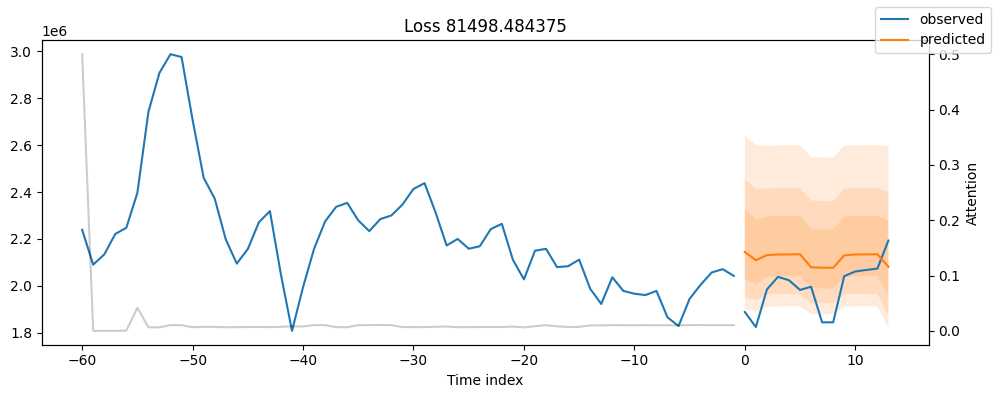

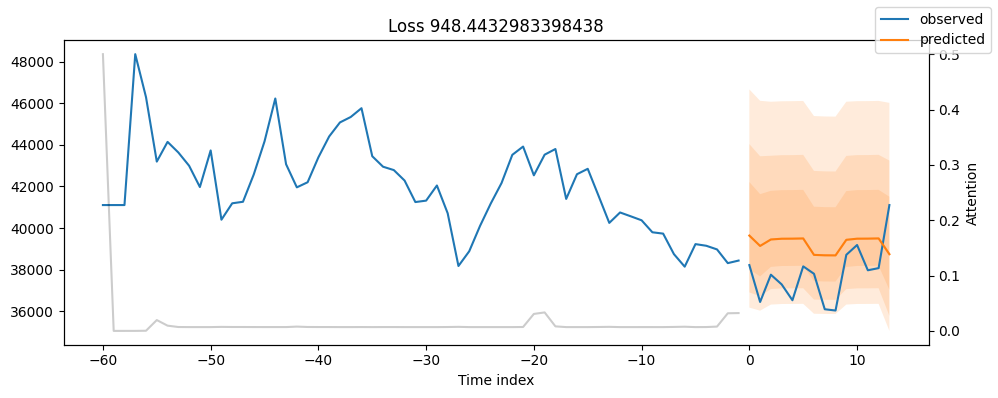

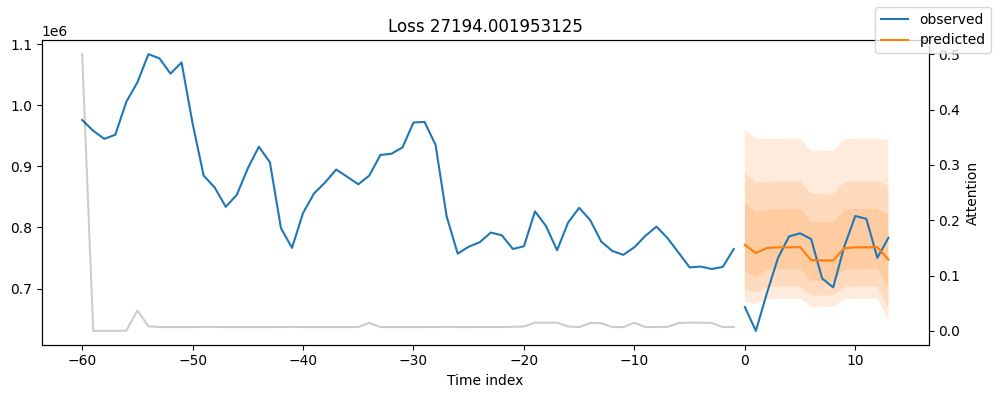

In [41]:
for idx in range(8):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)
